# Agent-Based Genetic Algorithm for the La Corona Model (a COVID-themed El Farol Model)

This is an implementation of a COVID-themed El Farol Model where instead of the population trying to decide to go to the bar, they're deciding which grocery store to go to each week given how populated the ones they went to were in the last few weeks. Some interesting differences between this model and the El Farol model is that every inidividual needs to go grocery shopping so it's possible, if the target capacity is low enough and the population great enough, that it's impossible to stay below the desired threshold for all grocery stores. Additionally, there are multiple centers in which the population can gain information. Therefore, individuals will not all have access to the same information each week. 

In [1]:
import numpy as np 
import random, operator, math
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:

# this creates a random strategy with random coefficients between -1 and 1 for each
# grocery store from 1 to mem weeks ago since each week it's possible for the person
# to have visited any of the grocery stores
def rand_strat(mem, n_groc):
    return np.random.random(mem * n_groc)*2-1

# this class has two dataframes, one that stores the strategies and another that stores
# the individuals history. The individual uses a genetic algorithm to develop the best strategy for 
# avoiding overfull stores
class Person:

    # this initialization creates n_strat random strategies, a randomized history for mem weeks
    # and calculates the score each strategy gives to each store (the score is a measure of how
    # much the strategy recommends a given store) and its fitness (the fitness optimizes for the
    # best strategy if it was applied over the past mem weeks)
    def __init__(self, n_strat, mem, n_groc, elite_prop, mut_rate):

        self.mut_rate = mut_rate
        self.mem = mem
        self.elite_prop = elite_prop
        self.n_groc = n_groc
        self.strategies = []

        # creates random strategies
        for i in range(n_strat):
            self.strategies.append(rand_strat(mem, n_groc))

        # creates names for columns in strategy of the form "A1", "A2", "B1" etc,
        # which correspond to each grocery story for a given number of weeks in the 
        # past. 
        names = []
        for w in range(mem):
            for g in range(n_groc):
                names.append(chr(g+65) + str(w))
        
        self.strategies = pd.DataFrame(self.strategies)
        self.strategies.columns = names

        groc = list(range(0,n_groc))
        groc = [x+65 for x in groc]
        groc = list(map(chr, groc))
        
        groc = pd.DataFrame(columns = groc)

        # adds empty columns for the scores of each grocery of the form "A", "B", "C" etc
        for g in groc:
            self.strategies[g] = 0

        # adds a column for the fitness
        self.strategies["fitness"] = 0

        # this creates a list of random grocery stores and random fullness levels
        # between 0 and 2. 
        hist_g = []
        hist_pop = []
        for i in range(2 * mem):
            hist_g.append(chr(random.randint(0,n_groc-1)+65))
            hist_pop.append(random.random()*2)

        # combines the lists into a dataframe with randomly generated grocery stores
        # for each 2*mem weeks so that one can apply the strategy to the past mem
        # weeks
        self.history = pd.DataFrame({"grocery":hist_g, "fullness":hist_pop})

        # calculates the scores and fitness of each stragegy based on the randomly generated history
        self.update_scores()

    
    # this function calculates the scores generated by the strategy coefficients and history
    # of each individual for each grocery store. It also calculates the fitness of the strategy
    # based on the history
    def update_scores(self):

        # resets scores to 0
        self.strategies[self.strategies.columns[-self.n_groc:]] = 0

        # iterates through each strategy
        for sindex, srow in self.strategies.iterrows():
            ctr = 0
            fitness = 0

            # iterates through mem rows of history
            for hindex, hrow in self.history.iterrows():
                if ctr == self.mem: break
                ctr += 1
                
                # adds the fullness of the grocery store from row hindex to the 
                # corresponding store's score column in the strategy dataframe
                srow[hrow.grocery] += srow[hrow.grocery + str(hindex)] * hrow.fullness
                
                # creates a dictionary that contains each store
                stores = {}
                for i in range(self.n_groc):
                    stores[chr(i+65)] = 0

                # creates scores for each store for the first mem rows in the history dataframe
                for i in range(self.mem):
                    index = hindex + i
                    stores[self.history.iloc[index,0]] += srow[self.history.iloc[index,0] + str(index-hindex)] *                                                                 hrow.fullness

                # takes the maximum score for the hindex row in the history dataframe
                top = max(stores, key=stores.get)

                # this if block increases fitness for strategies that recommend grocery stores that
                # end up being not full and decreases the fitness for strategies that recommend strategies
                # that end up being full
                if top == hrow.grocery and hrow.fullness <= 1: fitness += 1+hrow.fullness
                elif top == hrow.grocery and hrow.fullness > 1: fitness -= hrow.fullness
                elif top != hrow.grocery and hrow.fullness <= 1: fitness -= (1+hrow.fullness) / self.n_groc
                elif top != hrow.grocery and hrow.fullness > 1: fitness += hrow.fullness / self.n_groc

            srow.fitness = fitness
            self.strategies.loc[sindex] = srow

    # this function adds the store and fullness to the top of the history dataframe and removes the
    # oldest entry
    def update_history(self,store,fullness):
        self.history.loc[-1] = {'grocery': store, 'fullness': fullness}  # adding a row
        self.history.index = self.history.index + 1  # shifting index
        self.history.sort_index(inplace=True) 
        self.history.drop(self.history.tail(1).index,inplace=True)

    # returns the index of the strategy with the highest fitness
    def best_strategy(self):
        return self.strategies["fitness"].idxmax()

    # returns the store with the maximum score by the best strategy
    def choice(self):
        return (self.strategies.iloc[self.best_strategy(),-(self.n_groc+1):-1].idxmax(axis=1))

    # returns top elite_prop proportion of the strategies by  fitness
    def elite(self):
        n = round(self.elite_prop * len(self.strategies))
        return self.strategies.sort_values(by = ["fitness"], ascending = False).head(n)
                
    # this is the breeding function of the genetic algorithm. It takes the top elite_prop
    # proportion of the current strategies then recombines them until it has one less strategy
    # then it should. Then it takes the average of the coefficients of the elite and makes that
    # the last strategy
    def update_strategies(self):
        elite = self.elite()
        new_strats = elite
        
        # recombines the strategies by splitting them at a random index and taking the
        # first part of one random elite and the end part of another random elite.
        for i in range(len(elite),len(self.strategies)-1):
            p1 = random.randint(0,len(elite)-1)
            p2 = random.randint(0,len(elite)-1)
            split = random.randint(0,len(elite.iloc[p1])-self.n_groc-2)
            child = elite.iloc[p1][0:split].append(elite.iloc[p2][split:len(elite.iloc[p2])])
            new_strats = new_strats.append(child, ignore_index = True)
          
        # there is a mut_rate chance that one of the stratgies will be replaced with a randomly
        # generated strategy
        if random.random() < self.mut_rate:
            mut = random.randint(0,len(new_strats)-1)
            new_strats.iloc[mut] =  np.concatenate((rand_strat(self.mem, self.n_groc), 
                                                    np.array([0.]*(self.n_groc+1))))

        # adds a strategy that takes the mean of each coefficient in the elite
        avg = elite.mean()
        new_strats = new_strats.append(avg, ignore_index = True)

        self.strategies = new_strats


In [17]:
# this Model class creates a population of Person class objects and a dictionary that 
# holds the fullness and capacity of each store in the model.
class Model:

    # in this initialization a store dictionary is created with randomly generated fullness and
    # the capacity as indicated. It also creates a population of size popsize
    def __init__(self, popsize, n_strat, mem, elite_prop, mut_rate, n_groc, capacity):

        self.stores = {}
        self.population = []
    
        # this fills a dictionary where the key is the name of the grocery store of the form
        # "A","B" etc, and the value is 2 value list where index 0 has the number of people in the store
        # for the current week and the capacity of the store
        for i in range(n_groc):
            self.stores[chr(i+65)] = [random.randint(1,capacity*2),capacity]

        # this generates popsize Person objects and stores them in a one-dimensional list
        for i in range(popsize):
            self.population.append(Person(n_strat,mem,n_groc,elite_prop,mut_rate))

    # this function returns a list of the choices of each of the Person objects based on their
    # histories
    def choices(self):
        
        choices = []
        for i in range(len(self.population)):
            exp = self.stores[self.population[i].history.iloc[0,0]] 
            choices.append(self.population[i].choice())
        return choices
    
    # this updates the fullness of each store based on the choices of each Person in the population
    def update_fullness(self):

        choices = self.choices()
        for store in self.stores:
            self.stores[store][0] = choices.count(store)
        return choices

    # this function iterates through the population and updates each individuals
    # history based on their current choice and then updates their strategies and score based
    # on the new history. 
    def next_week(self):

        choices = self.update_fullness()
        for i in range(len(self.population)):
            store = choices[i]
            self.population[i].update_history(store = choices[i],
                                              fullness = self.stores[store][0] / self.stores[store][1])
            self.population[i].update_strategies()
            self.population[i].update_scores()
        
        return self.stores

    # this returns the average fitness of the populations' best strategies
    def avg_best_fitness(self):

        avg = self.population[0].strategies.iloc[self.population[0].best_strategy()]["fitness"]
        for i in range(1,len(self.population)):
            avg += self.population[i].strategies.iloc[self.population[i].best_strategy()]["fitness"]
        return avg / len(self.population)


    # this iterate the Model through n_weeks and displays different things based on
    # the parameters
    def run_model(self, n_weeks, avg_fitness = False, one_hist = False, 
                  one_strat = False, stores = False):
        
        lines = []
        for i in range(len(self.stores)+1):
            lines.append([])

        # iterates for n_weeks
        for i in range(n_weeks):

            # displays the stratey of the first person in the population for each week
            if one_strat: display(self.population[0].strategies)
            # dispalys the history of the first person in the population for each week
            if one_hist: display(self.population[0].history)
            m.next_week()
            
            for c in range(len(self.stores)):
                lines[c].append(self.stores[chr(c+65)][0])

            lines[len(self.stores)].append(self.avg_best_fitness())

        if avg_fitness:
            plt.plot(lines[len(self.stores)], color = "black")
            plt.xlabel("Weeks")
            plt.ylabel("Avg. Fitness of Top Strats")
            plt.show()

        if stores:
            # provides a list of 10 colors to ensure each store's fullness and capacity are differentiated
            colors = ['green','blue','orange','red','purple','yellow','brown','violet','gray','black']
            for l in range(len(self.stores)):
                plt.plot(lines[l], label = chr(l+65), color = colors[l])
                plt.axhline(y=self.stores[chr(l+65)][1], xmin=0, xmax=1, color = colors[l])
                plt.xlabel("Weeks")
                plt.ylabel("Number of People")
                plt.legend()
            plt.show()


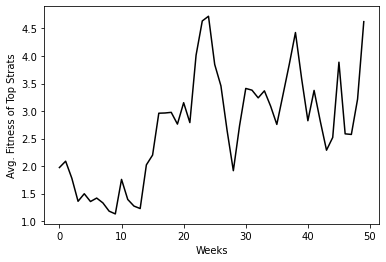

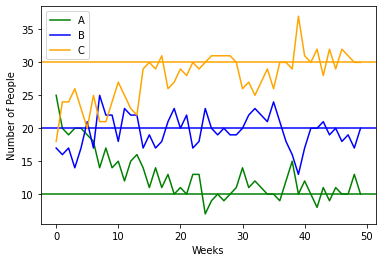

In [22]:
m = Model(popsize = 60,
          n_strat = 5,
          mem = 5,
          elite_prop = .2,
          mut_rate = .2,
          n_groc = 3,
          capacity = 50)

m.stores = {"A":[5 ,10],"B":[40,20],"C":[10,30]}

m.run_model(n_weeks = 50,
            avg_fitness = True,
            one_hist = False,
            one_strat = False,
            stores = True)